In [138]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic
from lenslessclass.datasets import MNISTAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


model_dir = "../MNIST_lens_down128_100epoch_logistic_reg"
model_dir = "../MNIST_tape_down128_100epoch_logistic_reg_BAD4"
model_dir = plib.Path(model_dir)

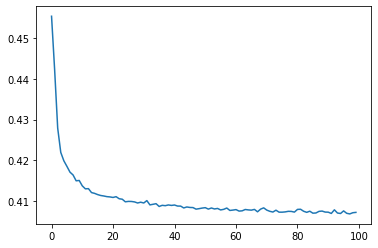

In [139]:
# load and plot error plots
test_loss_fp = str(model_dir / "test_loss.npy")
test_loss = np.load(test_loss_fp)
plt.plot(test_loss)

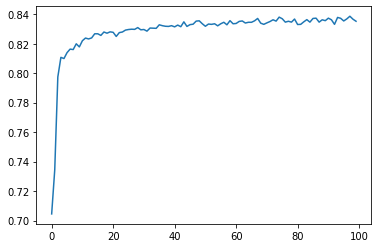

In [130]:
test_acc_fp = str(model_dir / "test_acc.npy")
test_acc = np.load(test_acc_fp)
plt.plot(test_acc)

# Confusion matrix on test set

In [131]:
# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'batch_size': 200,
 'best_test_acc': 0.8385999798774719,
 'best_test_acc_epoch': 98,
 'dataset': '/home/bezzam/LenslessClassification/data/MNIST_tape_down128',
 'mean': 0.32785919308662415,
 'model_param': {'input_shape': [23, 31], 'multi_gpu': True},
 'std': 0.24173006415367126}


In [132]:
# load test set
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)

In [133]:
# -- create model instance
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

# model = MultiClassLogistic(input_shape=output_dim, multi_gpu=multi_gpu)
model = MultiClassLogistic(**metadata["model_param"])
if use_cuda:
    model = model.to(device)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))

CUDA available, using GPU.


<All keys matched successfully>

In [134]:
criterion = nn.CrossEntropyLoss()

# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         if use_cuda:
#             images, labels = images.cuda(), labels.cuda()
#         # calculate outputs by running images through the network
#         outputs = model(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_cnt, running_loss = 0, 0
total_cnt = 0
for x, target in test_loader:

    # get inputs
    if use_cuda:
        x, target = x.cuda(), target.cuda()

    # forward, and compute loss
    out = model(x)
    loss = criterion(out, target)
    pred_label = torch.max(out.data, 1)[1]
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    running_loss += loss.item() / metadata["batch_size"]
_loss = running_loss
_acc = (correct_cnt * 1.0 / total_cnt).item()
print("test loss: {:.6f}, acc: {:.3f}".format( _loss, _acc))

test loss: 0.406834, acc: 0.839


In [135]:
# confusion matrix: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
y_pred = []
y_true = []

# iterate over test data
for x, target in test_loader:

    # get inputs
    if use_cuda:
        x, target = x.cuda(), target.cuda()

    out = model(x)
    output = (torch.max(out.data, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    target = target.data.cpu().numpy()
    y_true.extend(target) # Save Truth

Text(0.5, 42.0, 'Predicted')

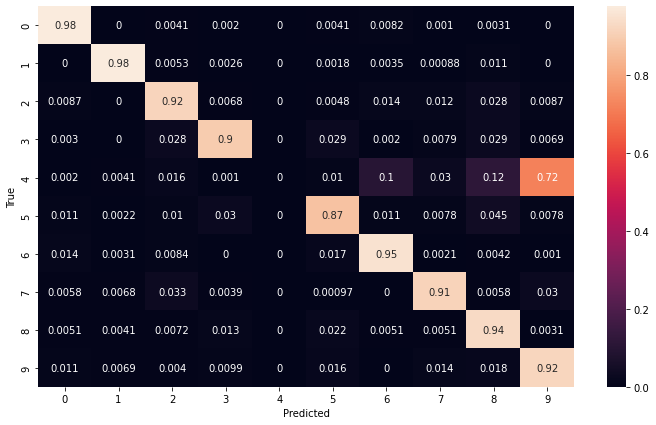

In [136]:
# Build confusion matrix
classes = np.arange(10)
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.ylabel("True")
plt.xlabel("Predicted")

In [137]:
print('Class distribution: %s' % np.bincount(y_true))

Class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
